# **Data Modeling and Analysis**
This includes findings from the mock poster on the conducted t-test as the statistic hypothesis test and the predictors created through machine learning.

# Statistic Hypothesis Test
For this, we'll be using the **time series hypothesis test** as described [here](https://elvyna.github.io/2018/time-series-hypothesis-testing/#:~:text=Time%20Series%20Hypothesis%20Test,have%20residuals%20of%20the%20series.).

The first thing we need to do is load our data set into the Python Notebook. Just for background, we have the tweets between the 25 December 2021 to 23 June 2023 which span the 45 days before the start of campaign period until 45 days after elections.

From this, we note the following important dates:
- Campaign period (for nationally elected positions): 8 Feb 2022 to 7 May 2022
- Election silence: 8 May 2022
- Election day (for non-absentee voters in the Philippines): 9 May 2022

In [ ]:
import pandas as pd

df = pd.read_csv('cs132_tweets_model_and_results.csv')
pd.set_option('display.max_colwidth', None)
df.head().style.set_properties(**{'text-align': 'left'})

,ID,"Account type ""Identified Anonymous Media""",Tweet Type,Tweet Type (2),Tweet Type (3),Date posted,Screenshot,Tweet ID,Tweet,Content type
0,00-1,Identified,Reply,nan,nan,12/26/21 22:35,00-1.png,1475113095395966976,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Rational
1,00-2,Identified,Reply,nan,nan,12/28/21 13:25,00-2.png,1475699422982189056,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.,Rational
2,00-3,Anonymous,Reply,nan,nan,12/29/21 20:47,00-3.png,1476173017458016256,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Emotional
3,00-4,Anonymous,Reply,nan,nan,01/07/22 14:37,00-4.png,1479341371219902464,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Emotional
4,00-5,Anonymous,Reply,nan,nan,01/08/22 06:25,00-5.png,1479580070922846208,AHAHAHAHA neri niyo NPA,Emotional


## Creating a daily tally of tweets
Here, we create a complete log of the included dates and the corresponding frequency of tweets for each day.

In [ ]:
# Copy the dataframe to one we can process
df_daily = df.copy()

# Transform the data to reflect daily logs
df_daily['Date posted'] = pd.to_datetime(df['Date posted'])
df_daily['Date posted'] = df_daily['Date posted'].dt.strftime('%Y-%m-%d')
df_daily['Date'] = pd.to_datetime(df_daily['Date posted'], format='%Y-%m-%d')

pd.set_option('display.max_colwidth', None)
df_daily.head().style.set_properties(**{'text-align': 'left'})

,ID,"Account type ""Identified Anonymous Media""",Tweet Type,Tweet Type (2),Tweet Type (3),Date posted,Screenshot,Tweet ID,Tweet,Content type,Date
0,00-1,Identified,Reply,nan,nan,2021-12-26,00-1.png,1475113095395966976,"@_ultravioletred @jersonality If their ED was done by a CPP cadre, the educator would've been reprimanded for sure. Whoever that educator is, they're probably still thinking in the 90s. Wake up kas, RA/RJ split is not that relevant anymore, lol. Embrace your comrades like what Neri, Labog, and Zarate did.",Rational,2021-12-26 00:00:00
1,00-2,Identified,Reply,nan,nan,2021-12-28,00-2.png,1475699422982189056,@lukatmhe Colmenarez family ay part sa legal front ng NPA. At saka may first cousin si Angel Locsin na big time drug dealer ng shabu sa Cebu. Siya ay former Local Beauty Queen. Mismo si Neri Colmenarez naki usap sa mga police na wag galawin or itumba.,Rational,2021-12-28 00:00:00
2,00-3,Anonymous,Reply,nan,nan,2021-12-29,00-3.png,1476173017458016256,"@weirdnow1 @pnagovph yay 😂😂😂 kaya pa nmn mag pakamatay yang sina Elago,Zarate,Colmenares,Nato Reyes sa pakiki bakbakan.Tanggaaa yung mga nasapi sa NPA",Emotional,2021-12-29 00:00:00
3,00-4,Anonymous,Reply,nan,nan,2022-01-07,00-4.png,1479341371219902464,@ColmenaresPH Shut Up Colmenares NPA. SALOT KA #Nerveagain,Emotional,2022-01-07 00:00:00
4,00-5,Anonymous,Reply,nan,nan,2022-01-08,00-5.png,1479580070922846208,AHAHAHAHA neri niyo NPA,Emotional,2022-01-08 00:00:00


In [ ]:
# Create a counts dataframe
s_freqinc = df_daily['Date'].value_counts()
df_freqinc = s_freqinc.to_frame()
df_freqinc.columns = ['Frequency']
df_freqinc.head()

# Create range of dates
new_dates = pd.date_range(start='2021-12-25',end='2022-06-23',freq='D')

# Reindex the dates
df_freq = df_freqinc.reindex(new_dates).fillna(0)
df_freq['Frequency'] = df_freq['Frequency'].astype('int')
df_freq.head()

,Frequency
2021-12-25,0
2021-12-26,1
2021-12-27,0
2021-12-28,1
2021-12-29,1


In [ ]:
df_datefreq = df_freq.copy()
df_datefreq['Date'] = df_datefreq.index
df_datefreq.reset_index(drop=True, inplace=True)
df_datefreq = df_datefreq[['Date', 'Frequency']]

df_freq.to_csv('cs132_datefreq.csv')
df_datefreq.head()

,Date,Frequency
0,2021-12-25,0
1,2021-12-26,1
2,2021-12-27,0
3,2021-12-28,1
4,2021-12-29,1


## Testing for stationarity

One of the diagnoses done in time series analyses is to test for stationarity, or whether the mean and variance of the time series is constant over time. This is important because many time series models and statistical tests assume that the time series is stationary.

A way to test for stationarity is through autocorrelation, in which we compare a time series to a copy of itself shifted backward in time ("lagged") to see whether past data is a good predictor of future data. We can do this by using the `autocorrelation_plot` function from the `pandas.plotting` module.

In the plot, a $y$-value of...

- $1$: means that the time series is perfectly correlated with itself at that lag (i.e., past data is a perfect predictor of future data),
- $0$: means that the time series is not correlated with itself at that lag (i.e., past data is not a good predictor of future data),
- $-1$ means that the time series is perfectly anti-correlated with itself at that lag (i.e., past data is a perfect inverse predictor of future data; large past data values is likely followed by smaller values).

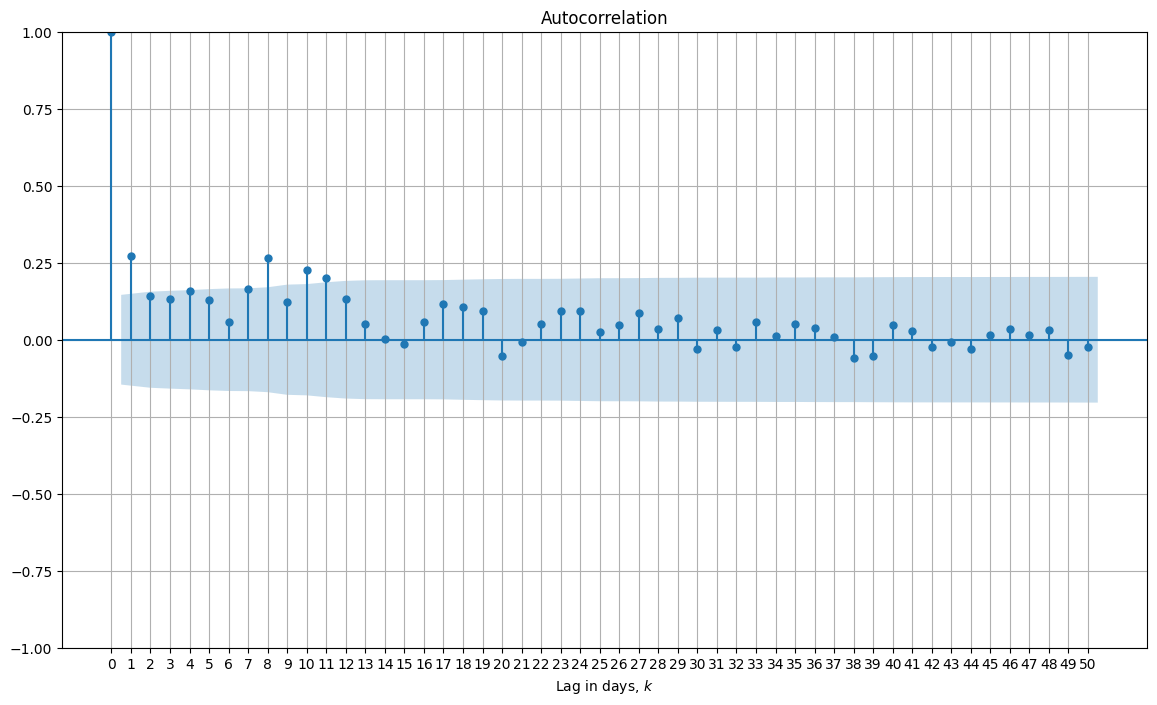

Largest ACF value: 0.2710252373376295 at lag k=1


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import statsmodels.api as sm

# Change lags here
lags = 50

with mpl.rc_context():
    mpl.rc("figure", figsize=(14,8))
    sm.graphics.tsa.plot_acf(df_freq['Frequency'], lags=lags)
    plt.grid()
    plt.xticks(np.arange(0, lags+1, 1.0))
    plt.xlabel('Lag in days, $k$')
    plt.show()

# Store ACF values and confidence intervals
acf_random, acf_random_confidence = sm.tsa.stattools.acf(df_freq['Frequency'], nlags=lags, alpha=0.05)

# Print largest ACF value excluding lag 0
max_acf = max(acf_random[1:])
print(f'Largest ACF value: {max_acf} at lag k={np.argmax(acf_random[1:]) + 1}')

The blue region in the plot represents the confidence interval, and any autocorrelation values outside this region are considered statistically significant. We can see from the plot that the autocorrelation values are mostly within the confidence interval, except for lags $k=1$, $k=8$, $k=10$, and $k=11$.

## Test for normality

In order to determine whether we can use a parametric or non-parametric test, we need to check if the data is normally distributed. We do this by using the Shapiro-Wilk test.

H0: The data is normally distributed

H1: The data is not normally distributed

In [ ]:
from scipy.stats import shapiro

# Normality tests
stat, p = shapiro(df_freq['Frequency'])
print('[Shapiro-Wilk] statistic=%.3f, p=%.25f' % (stat, p))
if p < 0.05:
  print('[Shapiro-Wilk] Reject H0 (not normally distributed)')
else:
  print('[Shapiro-Wilk] Do not reject H0 (normally distributed)')

[Shapiro-Wilk] statistic=0.761, p=0.0000000000000007134777684
[Shapiro-Wilk] Reject H0 (not normal)


## Mann-Whitney U test

Since the data was found to not be normally distributed, we have to use a non-parametric test. We use the Mann-Whitney U test to determine whether there is a significant difference between the averages of each period.

### Test 1: Before vs After Elections

H0: There is no difference between the frequency of tweets before and after elections.

H1: The frequency of tweets significantly change before and after elections.

- Election day (for non-absentee voters in the Philippines): 9 May 2022

In [ ]:
from scipy.stats import mannwhitneyu

# Create data groups
data_pre = df_datefreq[df_datefreq['Date'] < '2022-05-09']
data_post = df_datefreq[df_datefreq['Date'] > '2022-05-09']

# Perform Mann-Whitney U test
stat, p = mannwhitneyu(data_pre['Frequency'], data_post['Frequency'])
print('[Mann-Whitney] statistic=%.3f, p=%.25f' % (stat, p))
if p < 0.05:
  print('[Mann-Whitney] Reject H0 (significant difference)')
else:
  print('[Mann-Whitney] Do not reject H0 (no significant difference)')

[Mann-Whitney] statistic=4322.000, p=0.0000090593996920068365882
[Mann-Whitney] Reject H0 (significant difference)


We can see that $p<0.05$, leading us to the conclusion that **there is a significant difference between the average frequency of tweets before and after elections**.

### Test 2: During vs. Not During the Campaign Period
H0: There is no difference between the frequency of tweets included and excluded from the campaign period.

H1: The frequency of tweets significantly change included and excluded from the campaign period.

- Campaign period (for nationally elected positions): 8 Feb 2022 to 7 May 2022


In [ ]:
# Create data groups
mask = (df_datefreq['Date'] > '2022-02-08') & (df_datefreq['Date'] <= '2022-05-07')
data_inc = df_datefreq.loc[mask]
mask =  (df_datefreq['Date'] <= '2022-02-08') | (df_datefreq['Date'] > '2022-05-07')
data_ex = df_datefreq.loc[mask]

# Perform Mann-Whitney U test
stat, p = mannwhitneyu(data_inc['Frequency'], data_ex['Frequency'])
print('[Mann-Whitney] statistic=%.3f, p=%.25f' % (stat, p))
if p < 0.05:
  print('[Mann-Whitney] Reject H0 (significant difference)')
else:
  print('[Mann-Whitney] Do not reject H0 (no significant difference)')

[Mann-Whitney] statistic=5185.500, p=0.0011691632314091570006565
[Mann-Whitney] Reject H0 (significant difference)


We can see that $p<0.05$, leading us to the conclusion that **there is a significant difference between the average frequency of tweets during and not during the official campaign period**.

# Machine Learning
In this notebook, we follow instructions [here](https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1) to try and predict the expected number of tweets in a day based on the previous day using Time Series Forecasting.

In [ ]:
plt.rcParams['font.size'] = 30

df = pd.read_csv('cs132_datefreq.csv')
df.columns = ['Date', 'Frequency']
pd.set_option('display.max_colwidth', None)
df.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency
0,2021-12-25,0
1,2021-12-26,1
2,2021-12-27,0
3,2021-12-28,1
4,2021-12-29,1


First, we take a look at our data.

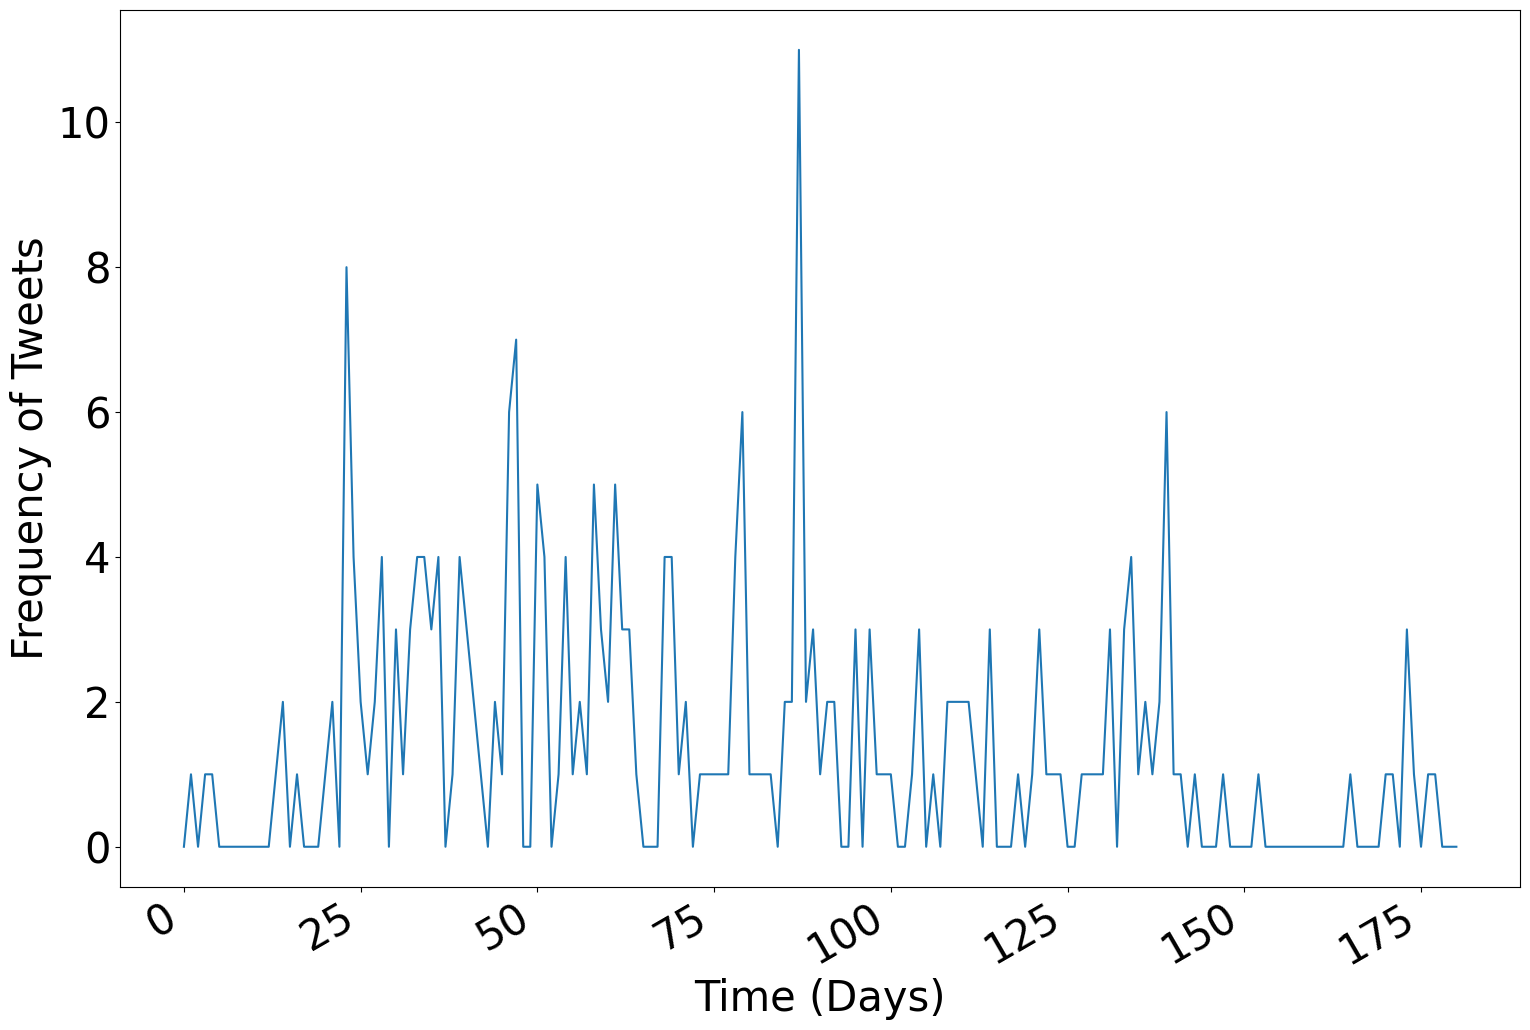

In [ ]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df['Frequency'])
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Frequency of Tweets')
fig.autofmt_xdate()
plt.tight_layout()

We then create the actual value we're trying to predict as "Next Day Frequency".

In [ ]:
df['Next Day Frequency'] = df['Frequency'].shift(-1)

Now, we split our data set into training and testing data. In this case, we try and use the data points prior to the start of the campaign period to predict the behavior of daily frequency throughout the time we cover.

In [ ]:
train = df[:45]
test = df[45:]
test = test.drop(test.tail(1).index) # Drop last row
train.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency
0,2021-12-25,0,1.000000
1,2021-12-26,1,0.000000
2,2021-12-27,0,1.000000
3,2021-12-28,1,1.000000
4,2021-12-29,1,0.000000


We create a baseline predictor that essentially just copies the frequency for ease of comparison later.

In [ ]:
test = test.copy()
test['Baseline Prediction'] = test['Frequency']

test.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency,Baseline Prediction
45,2022-02-08,1,6.000000,1
46,2022-02-09,6,7.000000,6
47,2022-02-10,7,0.000000,7
48,2022-02-11,0,0.000000,0
49,2022-02-12,0,5.000000,0


### Decision Tree

This model uses a simple decision tree with no cross-validation or hyperparameter tuning to perform regression on the training set and continuing on to predict throughout the test data set.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['Frequency'].values.reshape(-1,1)
y_train = train['Next Day Frequency'].values.reshape(-1,1)
X_test = test['Frequency'].values.reshape(-1,1)

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['Decision Tree Prediction'] = dt_pred

test.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency,Baseline Prediction,Decision Tree Prediction
45,2022-02-08,1,6.000000,1,1.400000
46,2022-02-09,6,7.000000,6,2.000000
47,2022-02-10,7,0.000000,7,4.000000
48,2022-02-11,0,0.000000,0,1.055556
49,2022-02-12,0,5.000000,0,1.055556


### Gradient Boosting

We now try a similar model frim `scikit-learn` so we can compare the results of the two.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['Gradient Boosting Prediction'] = gbr_pred

test.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency,Baseline Prediction,Decision Tree Prediction,Gradient Boosting Prediction
45,2022-02-08,1,6.000000,1,1.400000,1.400002
46,2022-02-09,6,7.000000,6,2.000000,1.999986
47,2022-02-10,7,0.000000,7,4.000000,3.999933
48,2022-02-11,0,0.000000,0,1.055556,1.055567
49,2022-02-12,0,5.000000,0,1.055556,1.055567


## Evaluation

We use the Mean Absolute Percentage Error to interpret how far/close our predictions are from the actual values and compare this across the models we've created.

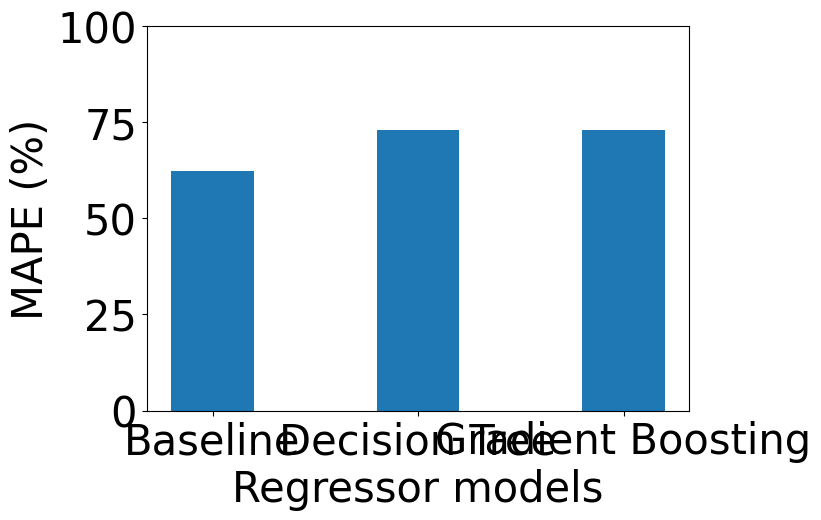

In [ ]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100, 2) # +1 to avoid division by zero

baseline_mape = mape(test['Next Day Frequency'], test['Baseline Prediction'])
dt_mape = mape(test['Next Day Frequency'], test['Decision Tree Prediction'])
gbr_mape = mape(test['Next Day Frequency'], test['Gradient Boosting Prediction'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 100)

plt.show()

## Visualizing its behavior

Now that we have our predictions, we can look at the behavior of the models compared to the actual value.

In [ ]:
df_combined = pd.concat([train, test], axis=0)

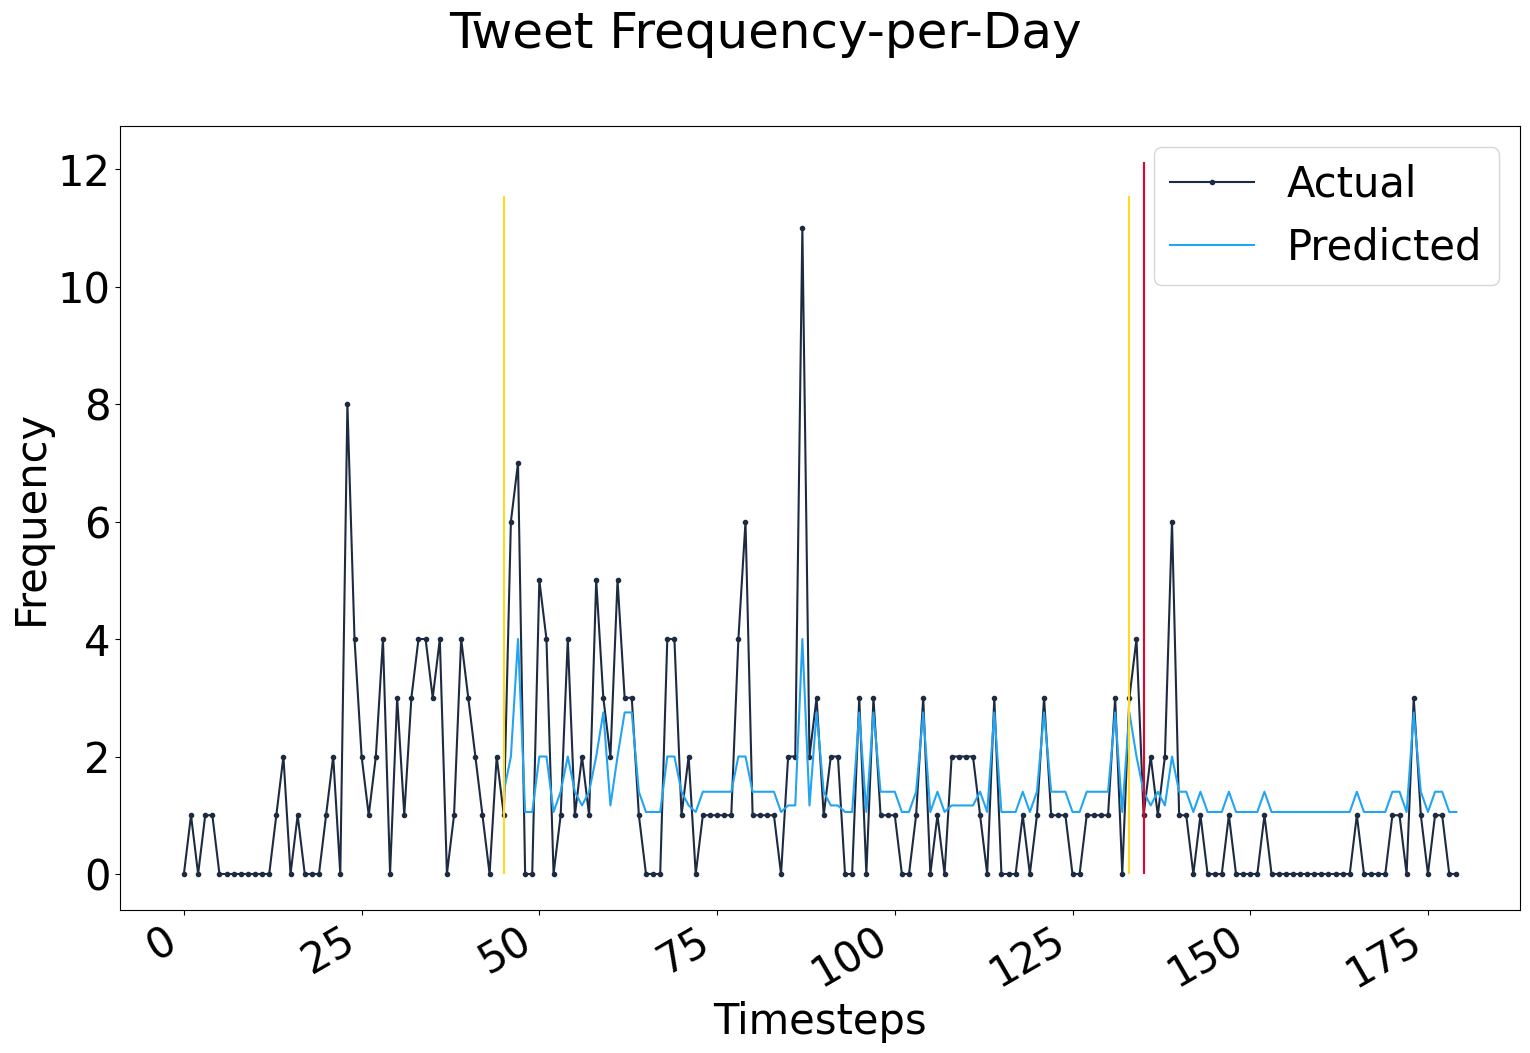

In [ ]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df_combined['Frequency'], marker='.', color='#1D2B42', label='Actual')
# ax.plot(df_combined['Baseline Prediction'], linestyle=':', color='gray', label='Baseline')
ax.plot(df_combined['Decision Tree Prediction'], linestyle='-', color='#22A4F2', label='Predicted')
# ax.plot(df_combined['Gradient Boosting Prediction'], linestyle=(0, (3, 10, 1, 10)), color='blue', label='Gradient Boosting')

plt.vlines(x = [45, 133], ymin = 0, ymax = max(ax.get_ylim()),
           colors = '#FFDA21')

plt.vlines(x = 135, ymin = 0, ymax = max(ax.get_ylim()),
           colors = '#E9012B')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Frequency')

plt.suptitle('Tweet Frequency-per-Day')
plt.legend(loc=1)
fig.autofmt_xdate()
plt.tight_layout()

Now we compare the behavior of the cumulative sums to help us look at the predicted cumulative frequency of tweets for each timestep.

In [ ]:
df_combined['Sum'] = df_combined['Frequency'].cumsum()
df_combined['BP Sum'] = df_combined['Baseline Prediction'].cumsum() + df_combined['Sum'][45]
df_combined['DT Sum'] = df_combined['Decision Tree Prediction'].cumsum() + df_combined['Sum'][45]
df_combined['GB Sum'] = df_combined['Gradient Boosting Prediction'].cumsum() + df_combined['Sum'][45]

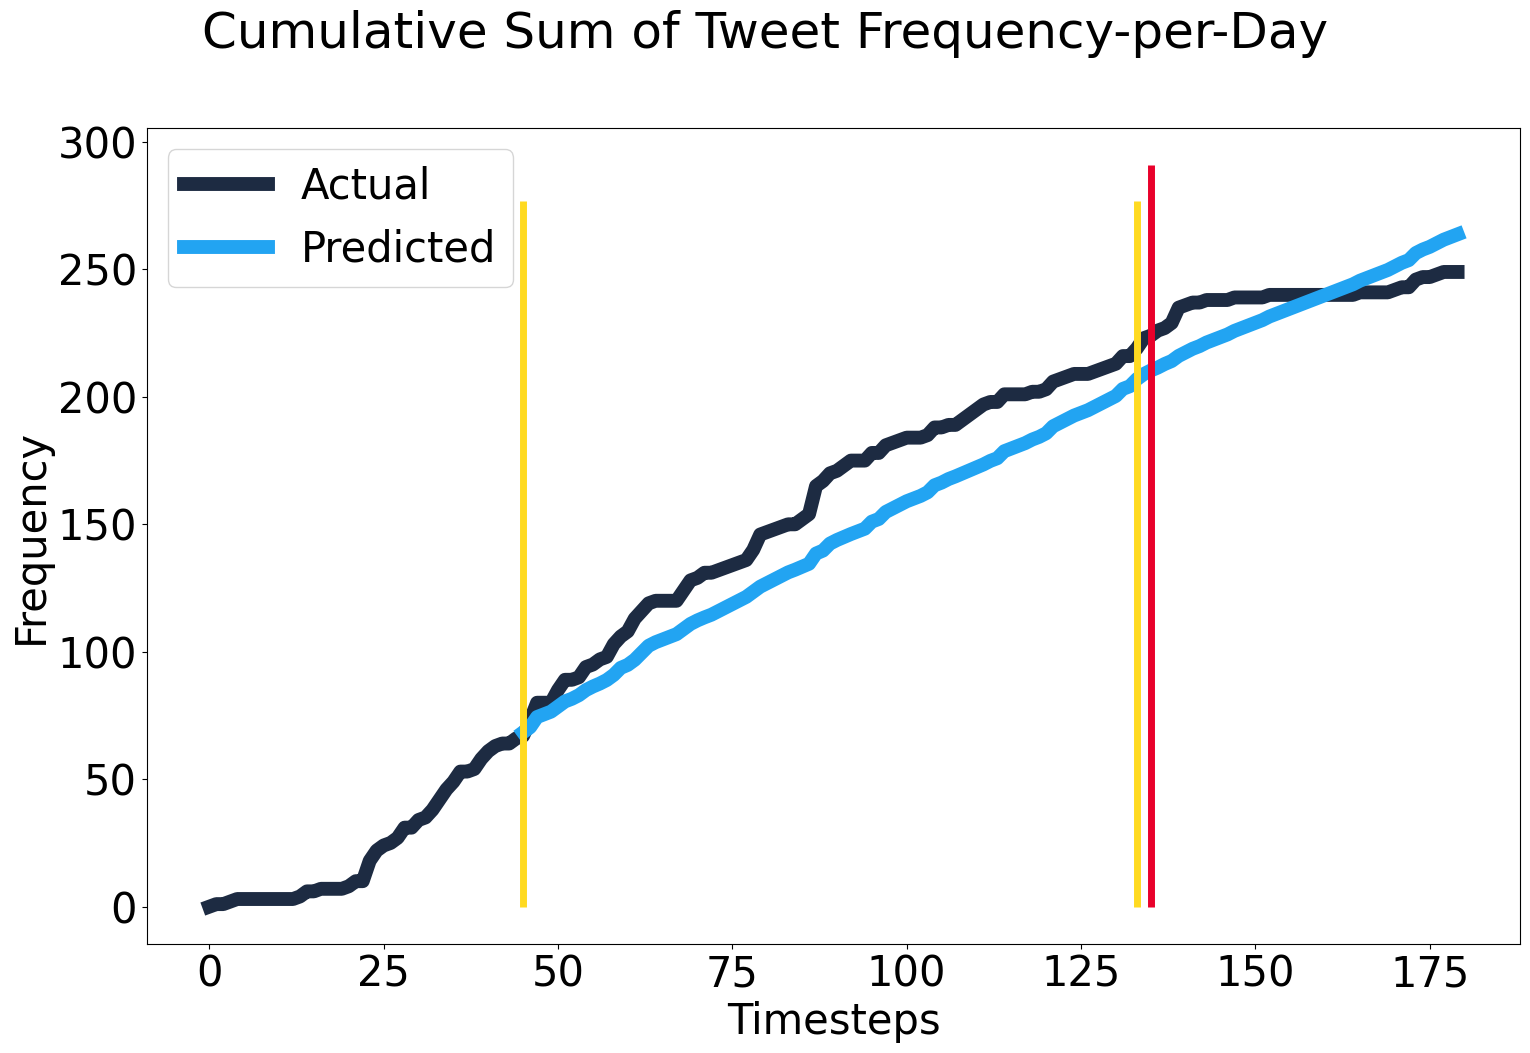

In [ ]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df_combined['Sum'], linestyle='-', color='#1D2B42', label='Actual', linewidth=10)
# ax.plot(df_combined['BP Sum'], marker='o', color='gray', label='Baseline')
ax.plot(df_combined['DT Sum'], linestyle='-', color='#22A4F2', label='Predicted', linewidth=10)
# ax.plot(df_combined['GB Sum'], linestyle=':', color='red', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Frequency')

plt.vlines(x = [45, 133], ymin = 0, ymax = max(ax.get_ylim()),
           colors = '#FFDA21',
           linewidth=5)

plt.vlines(x = 135, ymin = 0, ymax = max(ax.get_ylim()),
           colors = '#E9012B',
           linewidth=5)

plt.suptitle('Cumulative Sum of Tweet Frequency-per-Day')
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

As we can see, the actual value is much higher than any of our models' predictions but exploring other ways (different timesteps, training on cumulative sums, etc.) could lead to better performance. 